# Project 1 Goals ##

Our goal is to use the given data (and more, should be deem it necessary) to make recommendations to Microsoft about their new venture into movie-making. Our ultimate goal in this is to make recommendations that Microsoft can use to produce profitable movies. To do this, we need to understand what movies cost to make, what kind of movies are most profitable, and who to employ in our projects.

We begin with a bit of exploration about what factors are relevant in making a movie profitable. This means looking at factors like budget, rating, and genre to see if there is any connection to profitability there. Once we know what matters, we will have some idea what kind of movie we want to make; from there we can look at who to hire.

The primary questions this project aims to answer are:
1. How much should we expect to spend (i.e., what is the relation between budget and profit?)
2. What is the relation between ratings and profits?
3. What genre of film is most consistently profitable?
4. What director(s) should we hire for our project?
5. What writer(s) should we hire for our project? 

In [1]:
# import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patoolib
import os

In [2]:
# extract the files
patoolib.extract_archive('.\zippedData\\imdb.title.basics.csv.gz', outdir='Movie_Data')
patoolib.extract_archive('.\zippedData\\imdb.name.basics.csv.gz', outdir='Movie_Data')
patoolib.extract_archive('.\zippedData\\imdb.title.ratings.csv.gz', outdir='Movie_Data')
patoolib.extract_archive('.\zippedData\\imdb.title.principals.csv.gz', outdir='Movie_Data')
patoolib.extract_archive('.\zippedData\\tn.movie_budgets.csv.gz', outdir='Movie_Data')
patoolib.extract_archive('.\zippedData\\imdb.title.crew.csv.gz', outdir='Movie_Data')

# read data into dataframes
title_basics = pd.read_csv('.\Movie_Data\\imdb.title.basics.csv')
name_basics = pd.read_csv('.\Movie_Data\\imdb.name.basics.csv')
title_rate = pd.read_csv('.\Movie_Data\\imdb.title.ratings.csv')
title_prin = pd.read_csv('.\Movie_Data\\imdb.title.principals.csv')
budgets = pd.read_csv('.\Movie_Data\\tn.movie_budgets.csv')
title_crew = pd.read_csv('.\Movie_Data\\imdb.title.crew.csv')

patool: Extracting .\zippedData\imdb.title.basics.csv.gz ...
patool: ... .\zippedData\imdb.title.basics.csv.gz extracted to `Movie_Data'.
patool: Extracting .\zippedData\imdb.name.basics.csv.gz ...
patool: ... .\zippedData\imdb.name.basics.csv.gz extracted to `Movie_Data'.
patool: Extracting .\zippedData\imdb.title.ratings.csv.gz ...
patool: ... .\zippedData\imdb.title.ratings.csv.gz extracted to `Movie_Data'.
patool: Extracting .\zippedData\imdb.title.principals.csv.gz ...
patool: ... .\zippedData\imdb.title.principals.csv.gz extracted to `Movie_Data'.
patool: Extracting .\zippedData\tn.movie_budgets.csv.gz ...
patool: ... .\zippedData\tn.movie_budgets.csv.gz extracted to `Movie_Data'.
patool: Extracting .\zippedData\imdb.title.crew.csv.gz ...
patool: ... .\zippedData\imdb.title.crew.csv.gz extracted to `Movie_Data'.


Of these, the budgets dataframe provides information on both budget and gross income - it will be our main source for information about profitability. The dataframe labelled 'gross' does not include budget information, so it can't help us discover profitability.

The dataframes labelled with title all use an id system to label people and movies (see the columns 'tconst' and 'nconst'). This will require us to translate information into real title and people names in order to use it effectively.

First, however, we will clean up the budget dataframe.

## Budget & Profits

In [3]:
# since we are interested in modern trends, we exclude data from over 25 years ago.
budgets['release_date'] = pd.to_datetime(budgets['release_date'])
budgets = budgets.loc[budgets['release_date'] > '1995-1-1']

# remove duplicate titles
budgets = budgets.drop_duplicates(subset='movie')

# a function for turning money data into integer
def money_to_float(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].map(lambda x: x[1:].replace(',', '') if x[0] == '$' else x).astype(float)

# applying this function to the information about budgets in order to find out which movies turned the biggest profits
money_to_float(budgets, 'production_budget')
money_to_float(budgets, 'worldwide_gross')
money_to_float(budgets, 'domestic_gross')

#creating a column for net profits, as opposed to just gross, then displaying the top 5 profit-making movies
budgets['net'] = budgets['worldwide_gross'] - budgets['production_budget']
budgets.sort_values('net', ascending=False).head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
42,43,1997-12-19,Titanic,200000000.0,659363944.0,2.208208e+09,2.008208e+09
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,1.747311e+09
33,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,1.433855e+09


These results shouldn't surprise anyone - most of these movies have famously been on the top earners list for a long time. It's perhaps worth noting that we're using profits over gross here. The translation is a little imperfect since theaters take a cut from gross. However, since the cut from gross is roughly the same (percentagewise) for each film, this shouldn't impact our data too much. Moreover, if it turns out that these big-budget blockbusters made a lot of money but didn't actually turn a huge profit, that would be information worth knowing. Its lack of budget data means that we didn't use the 'bom movie gross' spreadsheet.

To answer question 1, or next step is to graph the relationship between budget and profits to determine if there is any connection. The code below produces that graph while also finding the correlation coefficient of the data.

The Correlation Coefficient of Budget against Net Profits is 0.633
The Correlation Coefficient of Budget against Net Profits is 0.767


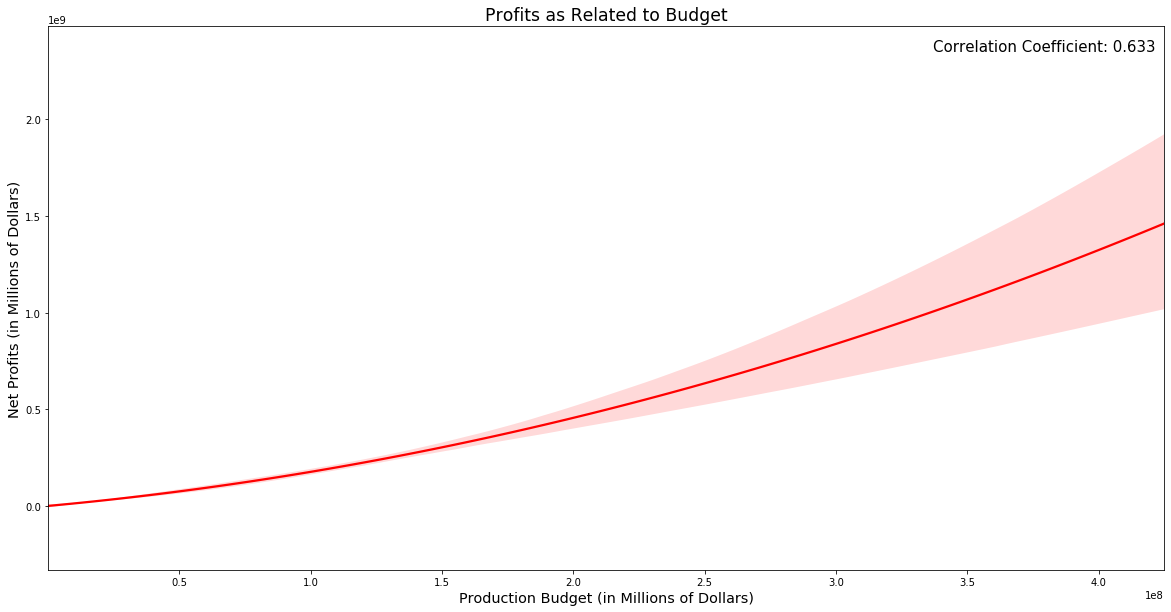

In [4]:
# we can then use this data to see how budget impacts profits. We downweight outliers because high-performing movies seem
# to include a lot of factors other than merely budget - we don't want to give too much weight to what could be a fluke
fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = sns.regplot(x='production_budget', y='net', data=budgets, order=2, scatter_kws={'color': 'white'}, line_kws={'color':'red'})
ax1.set_xlabel('Production Budget (in Millions of Dollars)', size='x-large')
ax1.set_ylabel('Net Profits (in Millions of Dollars)', size='x-large')
ax1.set_title('Profits as Related to Budget', size='xx-large')

# this finds the correlation coeffecient and displays it
cor = np.corrcoef(budgets['production_budget'], budgets['net'])[0][1]
print('The Correlation Coefficient of Budget against Net Profits is ' + str(round(cor, 3)))
ax1.text(337000000, 2350000000, 'Correlation Coefficient: ' + str(round(cor, 3)), size=15, color='black')


# to confirm and expand our findings, we can find the correlation between budget and gross as well
cor = np.corrcoef(budgets['production_budget'], budgets['worldwide_gross'])[0][1]
print('The Correlation Coefficient of Budget against Net Profits is ' + str(round(cor, 3)))

From this we can see that there is a reasonably strong connection between budget and profits, and an even stronger connection between budget and gross. 

Because profitability grows with budget, if we want to make a profit on this venture, we should be prepared to spend a decent amount of money. However, it's worth noting that budget does not increase profitably by a huge factor. As a result, two movies with a \$1.5M budget could be expected to make about as much as a single movie with \$3M budget. This becomes less true as you are willing to spend more money, but, depending on other goals, it could be wiser to make more cheaper movies to diversify our investment in this field. How much we want to spend will depend on how much we want to make, but the graph can provide us information on expected profits for any budget.

Next, in question 2, we look at another factor often though to influence a movie's profitability: ratings. 

## Ratings & Profits

The Correlation Coefficient of Ratings against Net Profits is 0.217


Text(0, 0.5, 'Profits (in Millions of Dollars)')

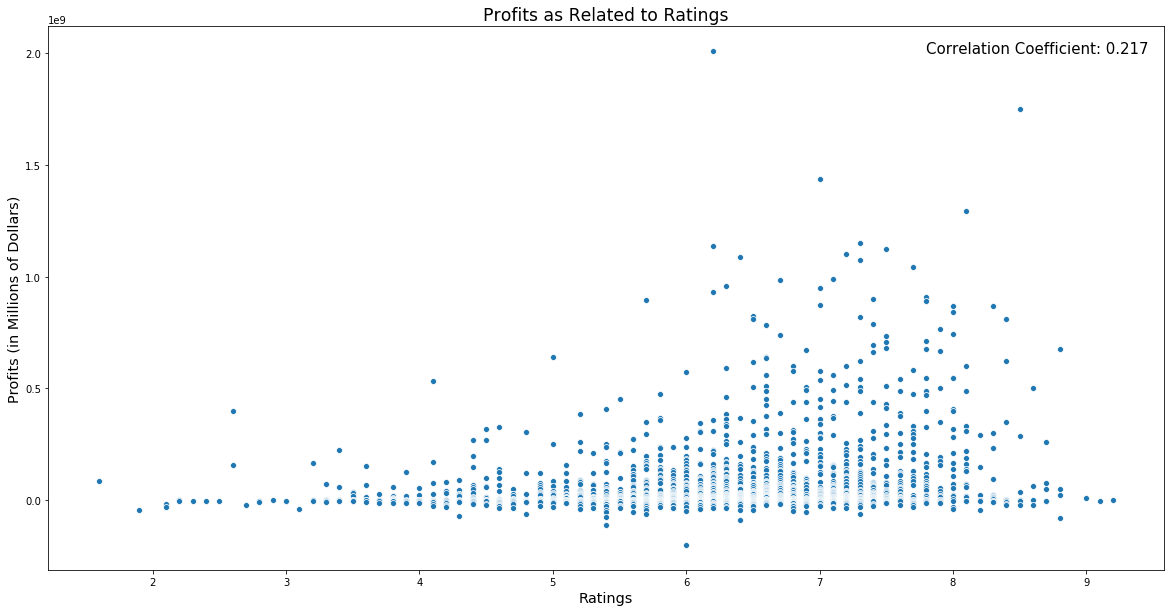

In [5]:
# next we check to see how ratings impact profits. First we merge ratings with titles to get genres, then merge with the
# budgets to get profit data related to ratings
rated_titles = title_basics.merge(title_rate, on='tconst')
rated_titles = rated_titles.rename(columns={'original_title': 'movie'})
rate_and_profit = rated_titles.merge(budgets, on='movie').sort_values('net', ascending=False)

# remove duplicate movies
rate_and_profit = rate_and_profit.drop_duplicates(subset='movie')

# let's graph that and print it's correlation coefficient as well
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x='averagerating', y='net', data=rate_and_profit)
cor_rate_profit = np.corrcoef(rate_and_profit['averagerating'], rate_and_profit['net'])[0][1]
print('The Correlation Coefficient of Ratings against Net Profits is ' + str(round(cor_rate_profit, 3)))
ax.text(7.8, 2000000000, 'Correlation Coefficient: ' + str(round(cor_rate_profit, 3)), size=15, color='black')
ax.set_title('Profits as Related to Ratings', size='xx-large')
ax.set_xlabel('Ratings', size='x-large')
ax.set_ylabel('Profits (in Millions of Dollars)', size='x-large')

If there were a real relationship between ratings and profits, we should see the points on this graph make a kind of line. Instead, they form a kind of cluster spread out along the bottom of the graph and growing wider between ratings of 6 and 8. What this means is that there is not a strong relationship between ratings and profits - we do not need to make a highly-rated movie to make strong profits. This is born out by the low correlation coefficient of .217. Ultimately, most any movie that can get a rating between 6 and 8 can be solidly profitable, and in fact most movies rated above 9 do not turn noteworthy profits. 

While this may be a purely negative conclusion, it does help us because it shows us we don't need to waste time thinking about what contributes to high movie ratings.

Ok. So we know that the more we spend, the more we can expect to make. We also know that we don't need to concern ourselves with critics - we can say goodbye to the haters. 

So now let's turn to question 3 and take a look at what genre of movie would be most profitable for us.

## Profitability by Genre

In [1]:
# next we are interested in finding a connection between genre and profits
for_merge = title_basics.rename(columns={'original_title': 'movie'})
budget_genre = budgets.merge(for_merge, on='movie')

# tidy it up a little for readability, remove null and duplicate values
budget_genre = budget_genre.drop(['start_year', 'runtime_minutes', 'id'], axis=1)
budget_genre = budget_genre.dropna()
budget_genre = budget_genre.drop_duplicates(subset='movie')


# most movies have multiple genres and it is necessary to break these out
budget_genre = budget_genre.set_index('movie').genres.str.split(',',
            expand=True).stack().reset_index(level=1, 
            drop=True).to_frame('genres').reset_index().merge(budget_genre, on='movie').drop(['genres_y', 'primary_title'], axis=1)

# we are then ready to plot the data and find average profits per genre
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x='genres_x', y='net', data=budget_genre.groupby('genres_x').mean().sort_values('net', ascending=False).head(15).reset_index())
    ax.set_title('Profits by Genre', size='xx-large')
    ax.set_xlabel('Genres', size='x-large')
    ax.set_ylabel('Profits (in Millions of Dollars)', size='x-large')

NameError: name 'title_basics' is not defined

This chart shows us that the most profitable genres are Animation, Adventure, and Sci-Fi. While Musical seems quite profitable, if you look more closely at the data it becomes clear that the Musical numbers are being propped up by the presence of a a large number of Disney movies. Since we don't have the same beloved intellectual properties as Disney, Musical will not really be a strong option for that. If we exclude those, the Musical score falls a good deal (Animation falls a little as well, naturally). 

This data suggests that we should create an animated sci-fi adventure. Luckily, this falls right into the Microsoft wheelhouse, as we can leverage our reputation as a technology company to generate interest in a technologically-innovative, computer-animated story.

Our next task (questions 4 and 5) is to put together a team for our movie. To do this, we will look at what directors and writers regularly turn out the most high-performing movies. With this information we can start putting together the perfect crew for the perfect movie.

## Most Profit-Generating Directors & Writers

In [ ]:
# begin by bringing in the crews info for each monvie
crews = title_crew.merge(title_basics, on='tconst')
crews = crews.rename(columns={'original_title': 'movie'})
crews = crews.drop_duplicates(subset='movie')

# expand the directors for which there are multiple directors
directors = crews.set_index('movie').directors.str.split(',',
            expand=True).stack().reset_index(level=1, 
            drop=True).to_frame('directors').reset_index()

# take this and add in the movie names and budgets
directors = directors.rename(columns={'directors': 'nconst'}).merge(name_basics, on='nconst').merge(budgets, 
                                        on='movie').drop(['id', 'death_year', 'birth_year', 'known_for_titles'], axis=1)

# we don't want to just sum earnings, since that would bias us towards those with the most movies, even if their movies were not
# consistently good. But if we use the mean, we risk being biased to new directors with just one good movie. So we filter out 
# newer directors and only then find the mean. This gives us the mean for experienced directors only.
directorial_film_count = pd.DataFrame(directors['primary_name'].value_counts()).reset_index().rename(columns={'index': 'name', 'primary_name': 'film_count'})
experienced_director_list = list(directorial_film_count.loc[directorial_film_count['film_count'] >= 4]['name'])
experienced_directors = directors.loc[directors['primary_name'].isin(experienced_director_list)].copy()
top_10_directors = experienced_directors.groupby('primary_name').mean().sort_values('net', ascending=False).reset_index().head(10)

In [ ]:
# now we're ready to make a bar graph of the best directors
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.barplot(x='primary_name', y='net', data=top_10_directors)
    ax.set_xlabel('Director Name', size='x-large')
    ax.set_xticklabels(top_10_directors['primary_name'], rotation=25)
    ax.set_title('Top Performing Directors by Average Film Profits', size='xx-large')
    ax.set_ylabel('Average Profits per Film \n (in millions of dollars)', size='x-large')

This graph corrobarates our genre information. Pierre Coffin, Chris Renaud, and Mike Mitchell are big animation directors and Christopher Nolan, Michael Bay, Bryan Singer, Francis Lawrence and Zack Snyder are directors of big-budget sci-fi adventure blockbusters. Depending on whether we choose to lean into animation or adventure, any of these directors would be an excellent choice. 

But a good director is nothing without a good script. So let's take a look now at the best-performing actors. The code to find them is essentially the same, mutatis mutandis, as the code for the directors.

In [ ]:
# expand the writers for movies where there are multiple writers. We use the same title and crew sheet as in the previous chart.
writers = crews.set_index('movie').writers.str.split(',',
            expand=True).stack().reset_index(level=1, 
            drop=True).to_frame('writers').reset_index()

# we take this and add in the movie names and budgets
writers = writers.rename(columns={'writers': 'nconst'}).merge(name_basics, on='nconst').merge(budgets, 
                                         on='movie').drop(['id', 'death_year', 'birth_year', 'known_for_titles'], axis=1)

# as before, we are concerned with the average earnings of experienced writers
writer_film_count = pd.DataFrame(writers['primary_name'].value_counts()).reset_index().rename(columns={'index': 'name', 'primary_name': 'film_count'})
experienced_writer_list = list(writer_film_count.loc[writer_film_count['film_count'] >= 4]['name'])
experienced_writers = writers.loc[writers['primary_name'].isin(experienced_writer_list)].copy()
top_10_writers = experienced_writers.groupby('primary_name').mean().sort_values('net', ascending=False).reset_index().head(10)

In [ ]:
# and the graph
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.barplot(x='primary_name', y='net', data=top_10_writers)
    ax.set_xlabel('Writer Name', size='x-large')
    ax.set_xticklabels(top_10_writers['primary_name'], rotation=35)
    ax.set_title('Top Performing Writers by Average Film Profits', size='xx-large')
    ax.set_ylabel('Average Profits per Film \n (in millions of dollars)', size='x-large')

As we might have expected, the results here are skewed towards writers who work on popular animated series and writers who work for major sci-fi adventure franchises. Again, depending on which way we lean, any of these writers would be an excellent choice.

## Summary & Next Steps

With that, we conclude this presentation on what movies to create. Here are some actionable insights for us going forward:

1. Be willing to spend a substantial amount of money if you want to see real return on investment. I recommend a \$4M budget, as the data shows that this kind of budget would yield a profit of about \$1.5M. A 37.5% profit of this kind is quite substantial.
2. Make an animated sci-fi adventure. From there we could lean into a family-oriented movie, but given our brand I feel a more cerebral action film might be better.
3. For such a film hire a director from our short list. For an action film, Christopher Nolan is our recommendation.
4. Hire a writer, also from our short list. Joss Whedon would be an excellent choice.

With more time, it would be interesting to consider whether having a big name like Bill Gates attached to the film could drive its profitability even if he is not known for any cinematic achievements. This could be done by evaluating the impact of a crew member's social media following on the film's profitability. If the findings are positive, having Gates sign on as a producer would really enable us to leverage our brand and increase profits. 

It would also be worth exploring the degree to which social media buzz is a driver of profits. We could see whether the talk around a movie has to be positive to generate profits or perhaps it might simply be enough to be talked about in general. If all we need is talk, then we could consider more dramatic and conversation-worthy gestures in the marketing buildup. But if talk has to be positive, we'll need to be more careful.